In [116]:
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVC
import re
import string
import unicodedata
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from emoji import demojize
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns

In [108]:
df = pd.read_csv("./../data/train.csv")

### Resampling

In [109]:
from sklearn.utils import resample

df_majority = df[df["label"] == 1]
df_minority = df[df["label"] == 0]
df_majority_downsampled = resample(df_majority, replace=True, n_samples=(len(df_minority)))
df_train_resampled = np.concatenate((df_majority_downsampled, df_minority), axis=0)
df_train_resampled = pd.DataFrame(df_train_resampled, columns=df.columns)

df = df_train_resampled
df

,label,text,id
0,1,Nobody cares what you think! Why do you think ...,6a8fa2aa5f7
1,1,buh naturally marriage suppose to be a Man and...,d1841a19771
2,1,What most folks don't understand is Christ doe...,7d3d42c6edf
3,1,Gays is the cause of HIV true fact,1f6913b6d99
4,1,cant believe our and other European government...,32d629e8159
...,...,...,...
10339,0,Live and let live is my motto who the hell are...,1a92cab6b9a
10340,0,Any city centre retirement project would be a ...,e7e64a3b9a0
10341,0,Just pick em up and lock m up or better yet ma...,fc4576f34e3
10342,0,There is something fundamentally wrong with this,fde30735725


### Pipeline

In [110]:
nltk.download("wordnet")
stop = set(stopwords.words("english"))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

# split test-training
X = df
y = df["label"].astype("int")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)


# preprocessing
def lower_case(text: str) -> str:
    """
    lower casing the whole text
    """
    return text.lower()


def stemming(text: str) -> str:
    """
    stems text from PorterStemmer in nltk
    """
    return " ".join([stemmer.stem(word=word) for word in text.split(" ")])


def lemmatizing(text: str) -> str:
    """
    lemmatizes text from WordNetLemmatizer in nltk
    """
    return " ".join(
        [lemmatizer.lemmatize(word=word, pos="n") for word in text.split(" ")]
    )


def remove_stopwords(text: str) -> str:
    """
    get rid of stopwords from english stopwords dict in nltk
    """
    return " ".join([word for word in text.split(" ") if word not in stop])


def noise_removal(text: str) -> str:
    """
    get rid of repeated items, urls, html tags, ellipsis, ect...
    """
    # text = re.sub(r'(\w+) \1', r'\1', text)
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"\.\.\.", " ", text)
    text = re.sub(r"\"", " ", text)
    text = (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )
    text = text.translate(str.maketrans("", "", string.punctuation))
    # text = re.sub(r"\s+", " ", text).strip()
    return text


def emoji_to_text(text: str) -> str:
    """
    convert emojis to english description words
    """
    return demojize(text, language="en")


def cleaned_text(text: str) -> str:
    """
    clean text by:
    1. emoji_to_text
    2. lower casing
    3. noise removal
    4. remove stopwords
    """
    text = emoji_to_text(text)
    text = lower_case(text)
    text = noise_removal(text)
    text = remove_stopwords(text)
    return text


def cleaned_text_transformer(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pandas ColumnTransformer
    """
    df["text"] = df["text"].apply(cleaned_text)
    return df


def lemma_transformer(df: pd.DataFrame) -> pd.DataFrame:
    """
    Pandas ColumnTransformer
    """
    df["text"] = df["text"].apply(lemmatizing)
    return df


class custom_tfidf(BaseEstimator, TransformerMixin):
    """
    For being able to use the TfidfVectorizer in the pipeline
    https://stackoverflow.com/a/54725859
    """

    def __init__(self, max_df=1.0, max_features=8000):
        self.max_df = max_df
        self.max_features = max_features
        self.tfidf = TfidfVectorizer(
            min_df=0, max_df=self.max_df, max_features=self.max_features
        )

    def fit(self, X, y=None):
        joined_X = X.apply(lambda x: " ".join(x), axis=1)
        self.tfidf.fit(joined_X)
        return self

    def transform(self, X):
        joined_X = X.apply(lambda x: " ".join(x), axis=1)
        return self.tfidf.transform(joined_X)



[nltk_data] Downloading package wordnet to /Users/apabook/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [111]:

pipeline_svc = Pipeline(
    [
        (
            "preprocessor",
            ColumnTransformer(
                [
                    (
                        "text_preprocess",
                        Pipeline(
                            [
                                (
                                    "text_process",
                                    FunctionTransformer(cleaned_text_transformer),
                                ),
                                ("text_lemma", FunctionTransformer(lemma_transformer)),
                                ("text_vector", custom_tfidf()),
                            ]
                        ),
                        ["text"],
                    )
                ]
            ),
        ),
        ("classifier", SVC()),
    ]
)

### Param Grid - GridSearchCV

In [112]:

param_grid = {
    "preprocessor__text_preprocess__text_vector__max_features": [5000, 6000, 8000],
    "preprocessor__text_preprocess__text_vector__max_df": [0.05, 0.15, 0.25, 0.35],
    "classifier__C": [10, 20, 30],
    "classifier__gamma": [1],
    "classifier__kernel": ["rbf"],
}

scoring = ["f1", "precision", "recall", "accuracy", "roc_auc"]
search = GridSearchCV(
    pipeline_svc, param_grid, scoring=scoring, n_jobs=20, verbose=True, refit="accuracy"
)
search.fit(X_train, y_train)
pipeline_svc


Fitting 5 folds for each of 36 candidates, totalling 180 fits


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text_preprocess',
                                                  Pipeline(steps=[('text_process',
                                                                   FunctionTransformer(func=<function cleaned_text_transformer at 0x1669f4040>)),
                                                                  ('text_lemma',
                                                                   FunctionTransformer(func=<function lemma_transformer at 0x1669579c0>)),
                                                                  ('text_vector',
                                                                   custom_tfidf())]),
                                                  ['text'])])),
                ('classifier', SVC())])

### Best Hyperparameters

In [113]:

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

y_pred = search.predict(X_test)
print("Accuracy in training ", metrics.accuracy_score(y_test, y_pred))
print("f-score in training ", metrics.f1_score(y_test, y_pred))

Best parameter (CV score=0.817):
{'classifier__C': 20, 'classifier__gamma': 1, 'classifier__kernel': 'rbf', 'preprocessor__text_preprocess__text_vector__max_df': 0.25, 'preprocessor__text_preprocess__text_vector__max_features': 6000}
Accuracy in training  0.8308361527307878
f-score in training  0.8297665369649806


### Metrics

              precision    recall  f1-score   support

           0       0.82      0.85      0.83      2042
           1       0.85      0.81      0.83      2096

    accuracy                           0.83      4138
   macro avg       0.83      0.83      0.83      4138
weighted avg       0.83      0.83      0.83      4138

[[1732  310]
 [ 390 1706]]


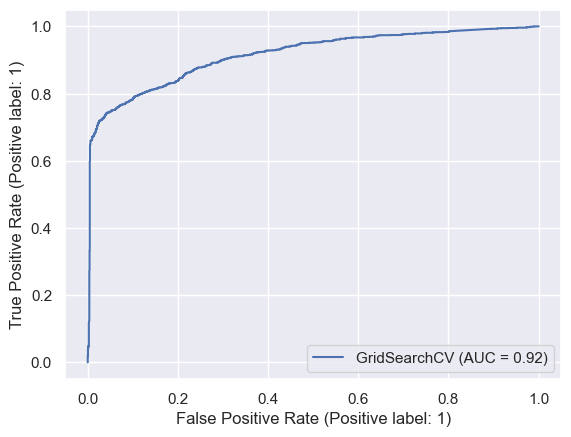

In [117]:
from sklearn.metrics import RocCurveDisplay, classification_report, confusion_matrix
sns.set(style="darkgrid")

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(RocCurveDisplay.from_estimator(search, X_test, y_test))

### Persist model

In [ ]:
import datetime


df_test = pd.read_csv("./../data/test_nolabel.csv")
y_pred = search.predict(df_test)
y_test_id = df_test["id"].values

now = datetime.datetime.now()
date_string = now.strftime("%Y%m%d_%H%M")
df_out = pd.DataFrame({'id': y_test_id, 'label': y_pred})
df_out.to_csv(f"./../data/submission_{date_string}.csv", index=False)